In [1]:

import os
from src import PROJECT_ROOT, DATA_DIR

import pandas as pd


C:\Users\tiend\PycharmProjects\Fair-Conference-Scheduling\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Plotting:

In [29]:
eval_path = os.path.join(PROJECT_ROOT, 'result', 'NeurIPS', '2024', '20250602_2158', 'eval.csv')
df = pd.read_csv(eval_path)

In [32]:
import plotly.express as px

# --- Metric groups ---
intracluster_metrics = ['avg_compactness', 'avg_diameter', 'max_diameter', 'worst_avg_spread']
objective_metrics = ['k-means', 'k-medoids']

# --- Plot 1: Intra-cluster Metrics ---
df_intracluster = df.melt(id_vars='model', value_vars=intracluster_metrics,
                          var_name='metric', value_name='value')

fig1 = px.bar(
    df_intracluster,
    x='metric',
    y='value',
    color='model',
    barmode='group',
    title="Intra-cluster Metrics Across Clustering Methods"
)
fig1.update_layout(template='plotly_dark')
fig1.show()

# --- Plot 2: Objective Scores ---
df_objectives = df.melt(id_vars='model', value_vars=objective_metrics,
                        var_name='metric', value_name='value')

fig2 = px.bar(
    df_objectives,
    x='metric',
    y='value',
    color='model',
    barmode='group',
    title="Objective Scores (k-means / k-medoids)"
)
fig2.update_layout(template='plotly_dark')
fig2.show()


In [2]:
iclr21 = os.path.join(PROJECT_ROOT, 'result', 'ICLR', '2021', '20250606_1308', 'eval.csv')
df21 = pd.read_csv(iclr21)
iclr22 = os.path.join(PROJECT_ROOT, 'result', 'ICLR', '2022', '20250606_1310', 'eval.csv')
df22 = pd.read_csv(iclr22)
iclr23 = os.path.join(PROJECT_ROOT, 'result', 'ICLR', '2023', '20250606_1312', 'eval.csv')
df23 = pd.read_csv(iclr23)
iclr24 = os.path.join(PROJECT_ROOT, 'result', 'ICLR', '2024', '20250606_1249', 'eval.csv')
df24 = pd.read_csv(iclr24)

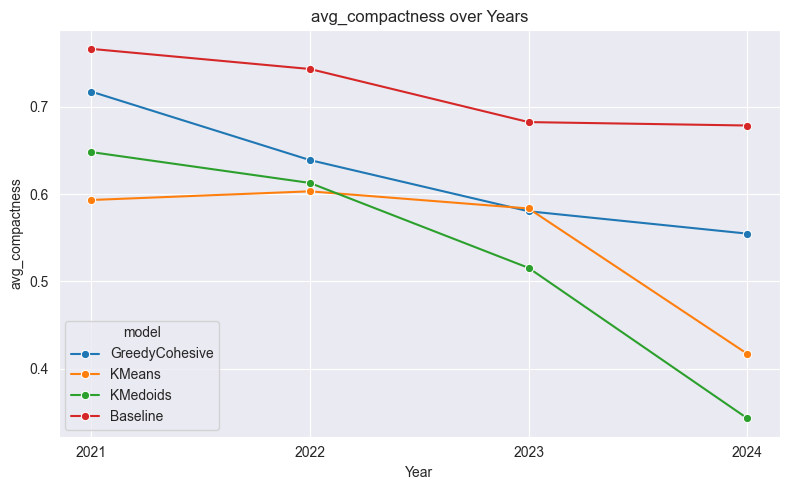

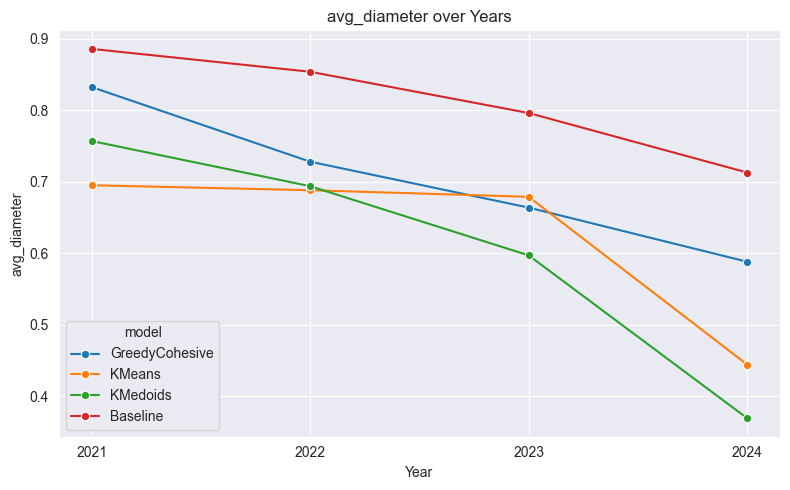

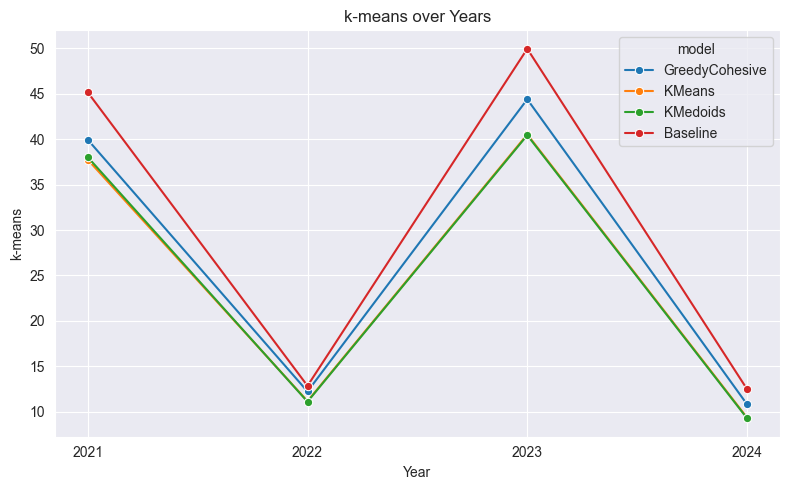

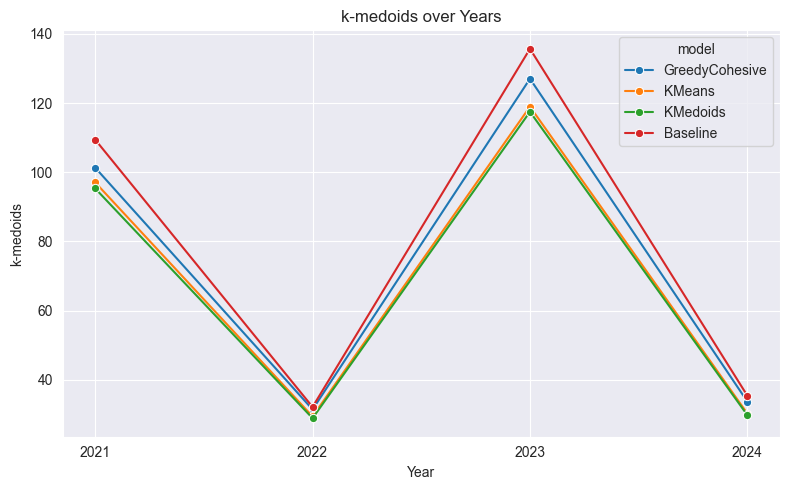

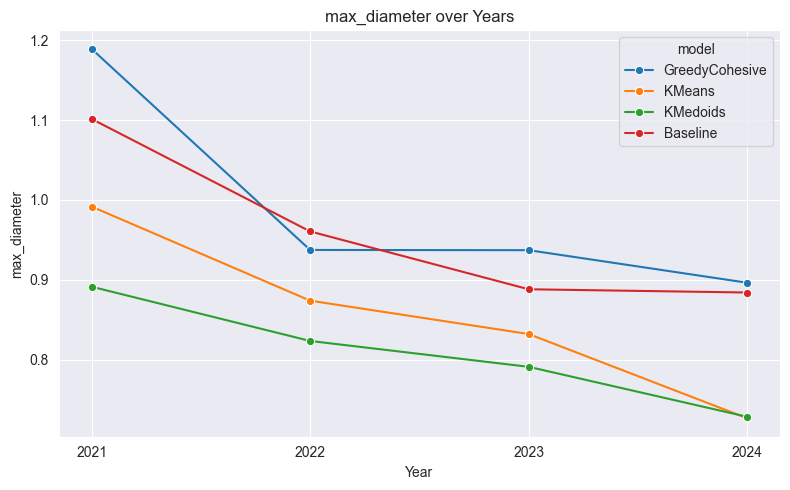

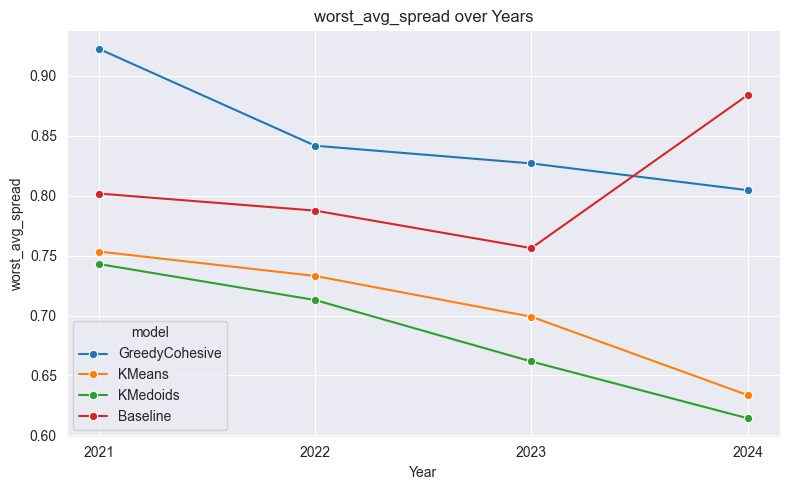

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have these 4 DataFrames loaded:
# df21, df22, df23, df24

# Add year to each dataframe
df21["year"] = 2021
df22["year"] = 2022
df23["year"] = 2023
df24["year"] = 2024

# Combine all years into one dataframe
df_all = pd.concat([df21, df22, df23, df24], ignore_index=True)

# Melt the dataframe for easier plotting
df_long = df_all.melt(id_vars=["model", "year"], var_name="metric", value_name="value")

# Plot each metric separately
metrics = df_long["metric"].unique()
for metric in metrics:
    plt.figure(figsize=(8, 5))
    subset = df_long[df_long["metric"] == metric]
    sns.lineplot(data=subset, x="year", y="value", hue="model", marker="o")
    plt.title(f"{metric} over Years")
    plt.xlabel("Year")
    plt.ylabel(metric)
    plt.grid(True)
    plt.xticks([2021, 2022, 2023, 2024])
    plt.tight_layout()
    plt.show()
